Early stopping at epoch 69
Epoch 100/1000, Loss: -0.4822
Early stopping at epoch 122
Epoch 100/1000, Loss: -0.1818
Early stopping at epoch 143
Early stopping at epoch 76
Epoch 100/1000, Loss: -0.0074
Early stopping at epoch 179
Epoch 100/1000, Loss: -0.0047
Early stopping at epoch 137
Early stopping at epoch 93
Epoch 100/1000, Loss: -0.1819
Epoch 200/1000, Loss: -0.1905
Early stopping at epoch 231
Early stopping at epoch 97
Epoch 100/1000, Loss: -1.9333
Early stopping at epoch 103


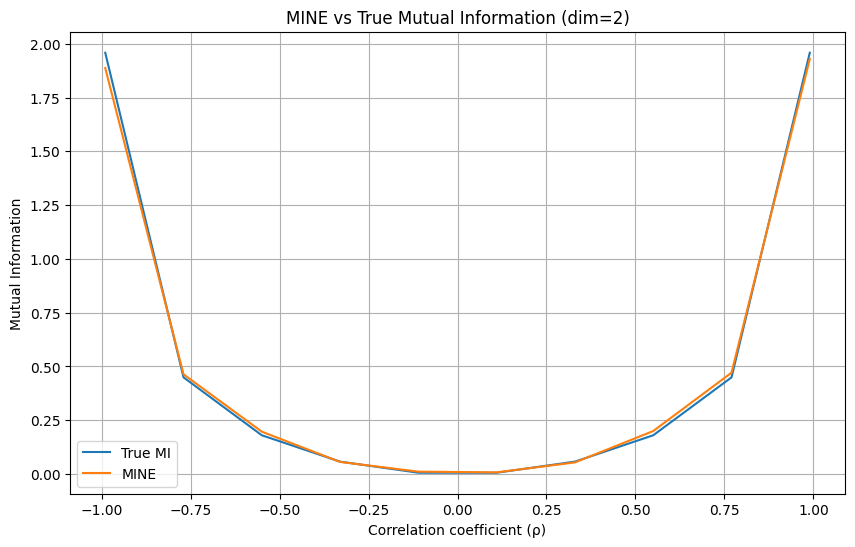

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

class MINENetwork(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x, y):
        return self.net(torch.cat([x, y], dim=1))

def sample_correlated_gaussian(rho, n_samples, dim):
    mean = np.zeros(dim)
    cov = np.eye(dim)
    cov[0, 1] = cov[1, 0] = rho
    return np.random.multivariate_normal(mean, cov, n_samples)

def mutual_information(rho, dim):
    return -0.5 * np.log(1 - rho**2)

def estimate_mi(net, x, y, x_shuffle):
    t = net(x, y).mean()
    et = torch.exp(net(x_shuffle, y)).mean()
    return t - torch.log(et)

def train_mine(rho, dim, n_samples=10000, n_iterations=1000, batch_size=200, patience=50):
    xy_samples = torch.tensor(sample_correlated_gaussian(rho, n_samples, dim), dtype=torch.float32)
    x = xy_samples[:, :dim//2]
    y = xy_samples[:, dim//2:]
    
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    net = MINENetwork(input_size=dim)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    
    best_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    for epoch in range(n_iterations):
        epoch_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x_shuffle = batch_x[torch.randperm(batch_x.size(0))]
            mi_est = estimate_mi(net, batch_x, batch_y, batch_x_shuffle)
            loss = -mi_est
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = net.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{n_iterations}, Loss: {avg_loss:.4f}")
    
    net.load_state_dict(best_model)
    
    with torch.no_grad():
        x_shuffle = x[torch.randperm(n_samples)]
        final_mi_est = estimate_mi(net, x, y, x_shuffle)
    
    return final_mi_est.item()

def run_experiment(dim):
    rho_values = np.linspace(-0.99, 0.99, 10)
    true_mi = [mutual_information(rho, dim) for rho in rho_values]
    estimated_mi = [train_mine(rho, dim) for rho in rho_values]
    
    plt.figure(figsize=(10, 6))
    plt.plot(rho_values, true_mi, label='True MI')
    plt.plot(rho_values, estimated_mi, label='MINE')
    plt.xlabel('Correlation coefficient (ρ)')
    plt.ylabel('Mutual Information')
    plt.title(f'MINE vs True Mutual Information (dim={dim})')
    plt.legend()
    plt.grid(True)
    plt.show()

run_experiment(dim=2)

Epoch 100/1000, Loss: -0.0164
Epoch 200/1000, Loss: -0.0258
Epoch 300/1000, Loss: -0.0308
Epoch 400/1000, Loss: -0.0384
Epoch 500/1000, Loss: -0.0495
Epoch 600/1000, Loss: -0.0517
Epoch 700/1000, Loss: -0.0652
Epoch 800/1000, Loss: -0.0599
Early stopping at epoch 832
Epoch 100/1000, Loss: -0.0192
Epoch 200/1000, Loss: -0.0339
Epoch 300/1000, Loss: -0.0488
Epoch 400/1000, Loss: -0.0560
Epoch 500/1000, Loss: -0.0656
Early stopping at epoch 564
Epoch 100/1000, Loss: -0.0246
Epoch 200/1000, Loss: -0.0479
Epoch 300/1000, Loss: -0.0612
Epoch 400/1000, Loss: -0.0813
Epoch 500/1000, Loss: -0.0760
Epoch 600/1000, Loss: -0.0951
Early stopping at epoch 639
Epoch 100/1000, Loss: -0.0259
Epoch 200/1000, Loss: -0.0449
Epoch 300/1000, Loss: -0.0626
Epoch 400/1000, Loss: -0.0711
Epoch 500/1000, Loss: -0.0825
Epoch 600/1000, Loss: -0.0928
Early stopping at epoch 609
Epoch 100/1000, Loss: -0.0311
Epoch 200/1000, Loss: -0.0457
Epoch 300/1000, Loss: -0.0656
Epoch 400/1000, Loss: -0.0775
Epoch 500/1000, Lo

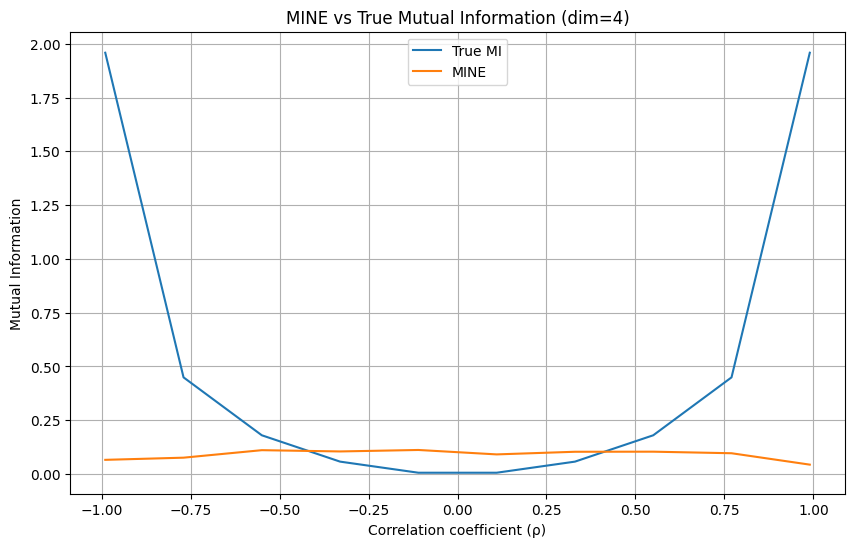

In [2]:
run_experiment(dim=4)

# Componentwise correlation -- like in the paper

Epoch 100/1000, Loss: -3.6603
Early stopping at epoch 129
Epoch 100/1000, Loss: -0.8980
Early stopping at epoch 113
Epoch 100/1000, Loss: -0.3523
Early stopping at epoch 161
Epoch 100/1000, Loss: -0.1310
Early stopping at epoch 114
Epoch 100/1000, Loss: -0.0317
Epoch 200/1000, Loss: -0.0534
Epoch 300/1000, Loss: -0.0637
Epoch 400/1000, Loss: -0.0795
Epoch 500/1000, Loss: -0.0895
Epoch 600/1000, Loss: -0.1013
Epoch 700/1000, Loss: -0.0999
Epoch 800/1000, Loss: -0.1144
Epoch 900/1000, Loss: -0.1169
Early stopping at epoch 940
Epoch 100/1000, Loss: -0.0432
Epoch 200/1000, Loss: -0.0637
Epoch 300/1000, Loss: -0.0756
Epoch 400/1000, Loss: -0.1022
Epoch 500/1000, Loss: -0.1018
Epoch 600/1000, Loss: -0.1142
Early stopping at epoch 687
Epoch 100/1000, Loss: -0.1352
Early stopping at epoch 136
Early stopping at epoch 78
Epoch 100/1000, Loss: -0.8687
Early stopping at epoch 125
Early stopping at epoch 61


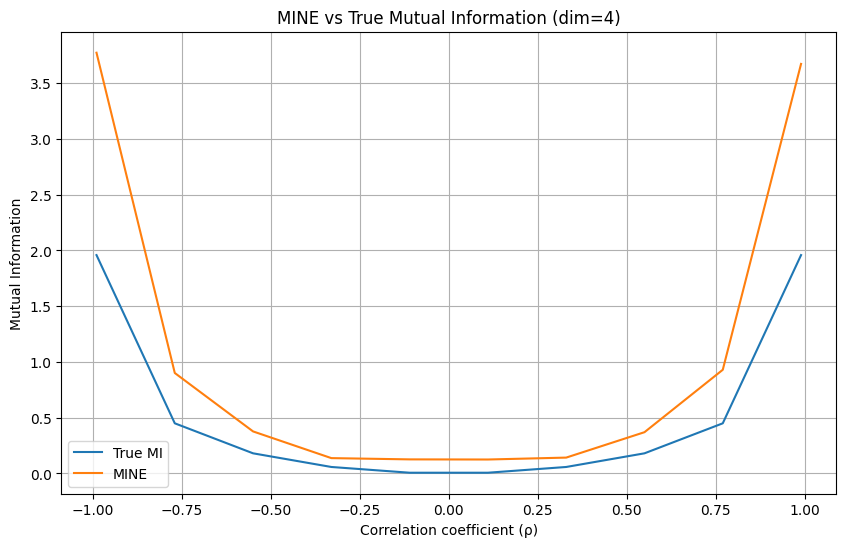

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

class MINENetwork(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x, y):
        return self.net(torch.cat([x, y], dim=1))

# def sample_correlated_gaussian(rho, n_samples, dim):
#     mean = np.zeros(dim)
#     cov = np.eye(dim)
#     for i in range(dim):
#         for j in range(dim):
#             if i != j:
#                 cov[i, j] = rho
#     return np.random.multivariate_normal(mean, cov, n_samples)

def sample_correlated_gaussian(rho, n_samples, dim):
    assert dim % 2 == 0, "Dimension must be even"
    half_dim = dim // 2
    
    mean = np.zeros(dim)
    cov = np.zeros((dim, dim))

    np.fill_diagonal(cov, 1.0)
    
    # correlations between corresponding dimensions
    for i in range(half_dim):
        cov[i, i + half_dim] = rho
        cov[i + half_dim, i] = rho
        
    return np.random.multivariate_normal(mean, cov, n_samples)

def mutual_information(rho, dim):
    return -0.5 * np.log(1 - rho**2)

def estimate_mi(net, x, y, x_shuffle):
    t = net(x, y).mean()
    et = torch.exp(net(x_shuffle, y)).mean()
    return t - torch.log(et)

def train_mine(rho, dim, n_samples=10000, n_iterations=1000, batch_size=200, patience=50):
    xy_samples = torch.tensor(sample_correlated_gaussian(rho, n_samples, dim), dtype=torch.float32)
    x = xy_samples[:, :dim//2]
    y = xy_samples[:, dim//2:]
    
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    net = MINENetwork(input_size=dim)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    
    best_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    for epoch in range(n_iterations):
        epoch_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x_shuffle = batch_x[torch.randperm(batch_x.size(0))]
            mi_est = estimate_mi(net, batch_x, batch_y, batch_x_shuffle)
            loss = -mi_est
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = net.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{n_iterations}, Loss: {avg_loss:.4f}")
    
    net.load_state_dict(best_model)
    
    with torch.no_grad():
        x_shuffle = x[torch.randperm(n_samples)]
        final_mi_est = estimate_mi(net, x, y, x_shuffle)
    
    return final_mi_est.item()

def run_experiment(dim):
    rho_values = np.linspace(-0.99, 0.99, 10)
    true_mi = [mutual_information(rho, dim) for rho in rho_values]
    estimated_mi = [train_mine(rho, dim) for rho in rho_values]
    
    plt.figure(figsize=(10, 6))
    plt.plot(rho_values, true_mi, label='True MI')
    plt.plot(rho_values, estimated_mi, label='MINE')
    plt.xlabel('Correlation coefficient (ρ)')
    plt.ylabel('Mutual Information')
    plt.title(f'MINE vs True Mutual Information (dim={dim})')
    plt.legend()
    plt.grid(True)
    plt.show()

run_experiment(dim=4)

Early stopping at epoch 70
Early stopping at epoch 74
Epoch 100/1000, Loss: -1.7839
Early stopping at epoch 107
Epoch 100/1000, Loss: -0.7049
Epoch 200/1000, Loss: -0.8749
Epoch 300/1000, Loss: -0.9319
Epoch 400/1000, Loss: -1.0666
Early stopping at epoch 480
Epoch 100/1000, Loss: -0.4831
Epoch 200/1000, Loss: -0.6019
Epoch 300/1000, Loss: -0.7427
Epoch 400/1000, Loss: -0.7623
Early stopping at epoch 466
Epoch 100/1000, Loss: -0.4641
Epoch 200/1000, Loss: -0.6409
Epoch 300/1000, Loss: -0.7095
Epoch 400/1000, Loss: -0.7657
Early stopping at epoch 403
Epoch 100/1000, Loss: -0.7358
Epoch 200/1000, Loss: -0.8451
Epoch 300/1000, Loss: -0.9788
Epoch 400/1000, Loss: -1.0168
Epoch 500/1000, Loss: -1.0686
Epoch 600/1000, Loss: -1.1627
Epoch 700/1000, Loss: -1.1821
Epoch 800/1000, Loss: -1.2326
Epoch 900/1000, Loss: -1.1804
Early stopping at epoch 946
Epoch 100/1000, Loss: -1.7809
Epoch 200/1000, Loss: -1.7928
Early stopping at epoch 233
Epoch 100/1000, Loss: -3.8306
Early stopping at epoch 175


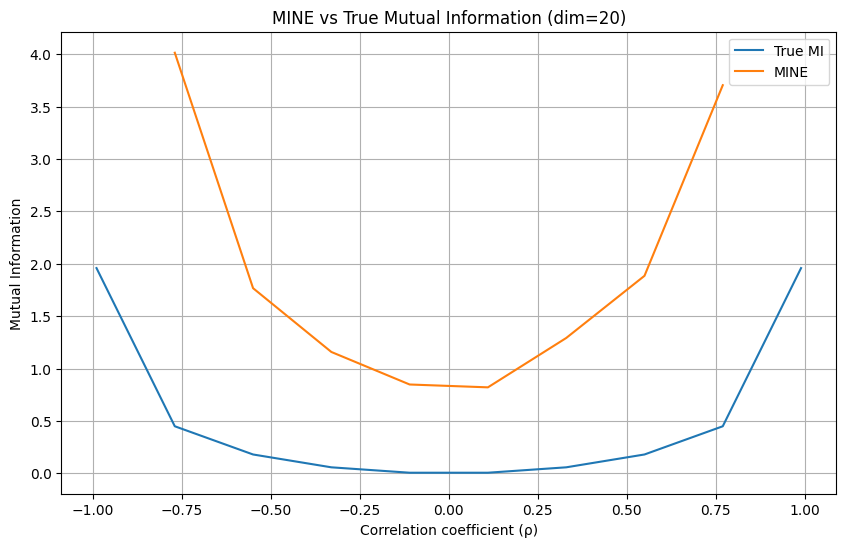

In [11]:
run_experiment(dim=20)

## Same net but more training data - the paper suggests to make the model linearly scalable with dim

/var/folders/jc/klfd_d3s1mvgd5xsggcywwb80000gn/T/ipykernel_98020/3158708117.py:51: RuntimeWarning: divide by zero encountered in log
  return n_pairs * (-0.5 * np.log(1 - rho**2))


Early stopping at epoch 71
Epoch 100/1000, Loss: -3.9685
Early stopping at epoch 103
Early stopping at epoch 83
Epoch 100/1000, Loss: -0.6621
Epoch 200/1000, Loss: -0.7194
Epoch 300/1000, Loss: -0.7875
Epoch 400/1000, Loss: -0.8064
Early stopping at epoch 451
Epoch 100/1000, Loss: -0.2504
Epoch 200/1000, Loss: -0.3590
Epoch 300/1000, Loss: -0.3870
Epoch 400/1000, Loss: -0.4385
Epoch 500/1000, Loss: -0.4464
Epoch 600/1000, Loss: -0.4920
Epoch 700/1000, Loss: -0.4826
Early stopping at epoch 757
Epoch 100/1000, Loss: -0.2526
Epoch 200/1000, Loss: -0.3397
Epoch 300/1000, Loss: -0.3938
Early stopping at epoch 378
Epoch 100/1000, Loss: -0.6563
Epoch 200/1000, Loss: -0.7093
Epoch 300/1000, Loss: -0.7656
Early stopping at epoch 359
Epoch 100/1000, Loss: -1.7504
Early stopping at epoch 162
Epoch 100/1000, Loss: -4.4454
Early stopping at epoch 132
Early stopping at epoch 67


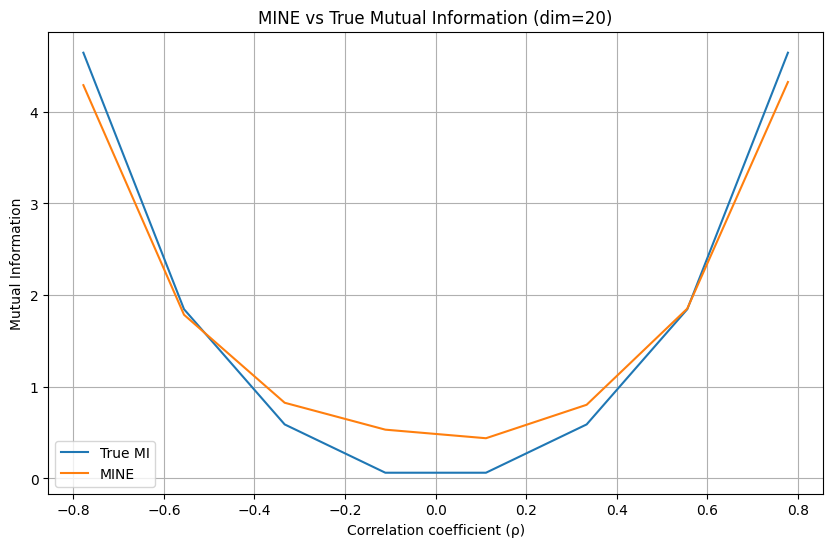

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

class MINENetwork(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x, y):
        return self.net(torch.cat([x, y], dim=1))

# def sample_correlated_gaussian(rho, n_samples, dim):
#     mean = np.zeros(dim)
#     cov = np.eye(dim)
#     for i in range(dim):
#         for j in range(dim):
#             if i != j:
#                 cov[i, j] = rho
#     return np.random.multivariate_normal(mean, cov, n_samples)

def sample_correlated_gaussian(rho, n_samples, dim):
    # Ensure dim is even
    assert dim % 2 == 0, "Dimension must be even"
    half_dim = dim // 2
    
    mean = np.zeros(dim)
    cov = np.zeros((dim, dim))
    
    # Set diagonal to 1 (variances)
    np.fill_diagonal(cov, 1.0)
    
    # Set correlations only between corresponding dimensions
    for i in range(half_dim):
        cov[i, i + half_dim] = rho
        cov[i + half_dim, i] = rho
        
    return np.random.multivariate_normal(mean, cov, n_samples)

def mutual_information(rho, dim):
    n_pairs = dim // 2
    return n_pairs * (-0.5 * np.log(1 - rho**2))

def estimate_mi(net, x, y, x_shuffle):
    t = net(x, y).mean()
    et = torch.exp(net(x_shuffle, y)).mean()
    return t - torch.log(et)

def train_mine(rho, dim, n_samples=20000, n_iterations=1000, batch_size=512, patience=50):
    xy_samples = torch.tensor(sample_correlated_gaussian(rho, n_samples, dim), dtype=torch.float32)
    x = xy_samples[:, :dim//2]
    y = xy_samples[:, dim//2:]
    
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    net = MINENetwork(input_size=dim)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    
    best_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    for epoch in range(n_iterations):
        epoch_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x_shuffle = batch_x[torch.randperm(batch_x.size(0))]
            mi_est = estimate_mi(net, batch_x, batch_y, batch_x_shuffle)
            loss = -mi_est
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = net.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{n_iterations}, Loss: {avg_loss:.4f}")
    
    net.load_state_dict(best_model)
    
    with torch.no_grad():
        x_shuffle = x[torch.randperm(n_samples)]
        final_mi_est = estimate_mi(net, x, y, x_shuffle)
    
    return final_mi_est.item()

def run_experiment(dim):
    rho_values = np.linspace(-1.0, 1.0, 10)
    true_mi = [mutual_information(rho, dim) for rho in rho_values]
    estimated_mi = [train_mine(rho, dim) for rho in rho_values]
    
    plt.figure(figsize=(10, 6))
    plt.plot(rho_values, true_mi, label='True MI')
    plt.plot(rho_values, estimated_mi, label='MINE')
    plt.xlabel('Correlation coefficient (ρ)')
    plt.ylabel('Mutual Information')
    plt.title(f'MINE vs True Mutual Information (dim={dim})')
    plt.legend()
    plt.grid(True)
    plt.show()

run_experiment(dim=20)

/var/folders/jc/klfd_d3s1mvgd5xsggcywwb80000gn/T/ipykernel_98020/230622588.py:51: RuntimeWarning: divide by zero encountered in log
  return n_pairs * (-0.5 * np.log(1 - rho**2))


Early stopping at epoch 60
Epoch 100/1000, Loss: -2.1979
Early stopping at epoch 175
Epoch 100/1000, Loss: -0.9290
Early stopping at epoch 116
Epoch 100/1000, Loss: -0.3121
Epoch 200/1000, Loss: -0.3382
Epoch 300/1000, Loss: -0.3631
Epoch 400/1000, Loss: -0.3790
Epoch 500/1000, Loss: -0.3945
Early stopping at epoch 560
Epoch 100/1000, Loss: -0.0876
Epoch 200/1000, Loss: -0.1186
Epoch 300/1000, Loss: -0.1383
Epoch 400/1000, Loss: -0.1477
Epoch 500/1000, Loss: -0.1585
Epoch 600/1000, Loss: -0.1616
Early stopping at epoch 644
Epoch 100/1000, Loss: -0.0853
Epoch 200/1000, Loss: -0.1175
Epoch 300/1000, Loss: -0.1277
Epoch 400/1000, Loss: -0.1460
Epoch 500/1000, Loss: -0.1565
Epoch 600/1000, Loss: -0.1662
Epoch 700/1000, Loss: -0.1682
Early stopping at epoch 770
Epoch 100/1000, Loss: -0.3240
Epoch 200/1000, Loss: -0.3409
Epoch 300/1000, Loss: -0.3667
Epoch 400/1000, Loss: -0.3863
Epoch 500/1000, Loss: -0.3788
Epoch 600/1000, Loss: -0.3883
Early stopping at epoch 612
Early stopping at epoch 9

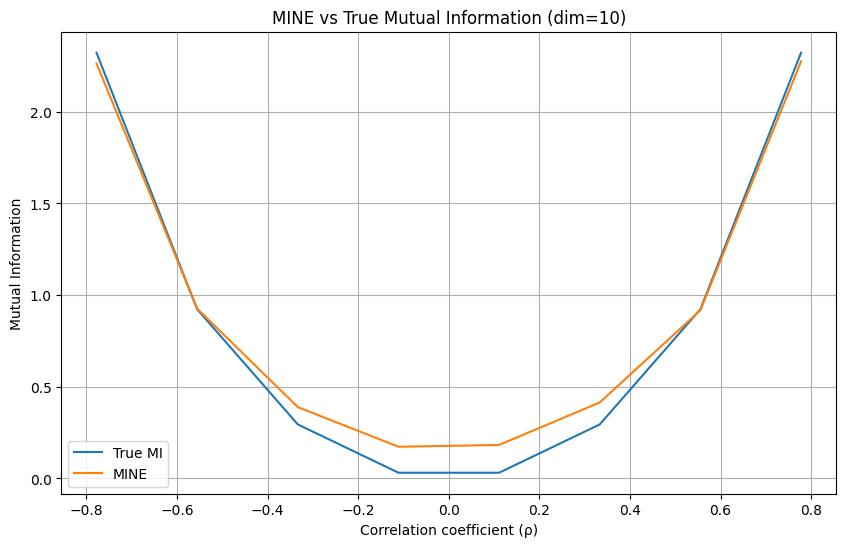

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

class MINENetwork(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x, y):
        return self.net(torch.cat([x, y], dim=1))

# def sample_correlated_gaussian(rho, n_samples, dim):
#     mean = np.zeros(dim)
#     cov = np.eye(dim)
#     for i in range(dim):
#         for j in range(dim):
#             if i != j:
#                 cov[i, j] = rho
#     return np.random.multivariate_normal(mean, cov, n_samples)

def sample_correlated_gaussian(rho, n_samples, dim):
    assert dim % 2 == 0, "Dimension must be even"
    half_dim = dim // 2
    
    mean = np.zeros(dim)
    cov = np.zeros((dim, dim))
    
    np.fill_diagonal(cov, 1.0)
    
    # correlation between corresponding dimensions
    for i in range(half_dim):
        cov[i, i + half_dim] = rho
        cov[i + half_dim, i] = rho
        
    return np.random.multivariate_normal(mean, cov, n_samples)

def mutual_information(rho, dim):
    n_pairs = dim // 2
    return n_pairs * (-0.5 * np.log(1 - rho**2))

def estimate_mi(net, x, y, x_shuffle):
    t = net(x, y).mean()
    et = torch.exp(net(x_shuffle, y)).mean()
    return t - torch.log(et)

def train_mine(rho, dim, n_samples=20000, n_iterations=1000, batch_size=512, patience=50):
    xy_samples = torch.tensor(sample_correlated_gaussian(rho, n_samples, dim), dtype=torch.float32)
    x = xy_samples[:, :dim//2]
    y = xy_samples[:, dim//2:]
    
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    net = MINENetwork(input_size=dim)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    
    best_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    for epoch in range(n_iterations):
        epoch_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x_shuffle = batch_x[torch.randperm(batch_x.size(0))]
            mi_est = estimate_mi(net, batch_x, batch_y, batch_x_shuffle)
            loss = -mi_est
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = net.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{n_iterations}, Loss: {avg_loss:.4f}")

    net.load_state_dict(best_model)

    with torch.no_grad():
        x_shuffle = x[torch.randperm(n_samples)]
        final_mi_est = estimate_mi(net, x, y, x_shuffle)
    
    return final_mi_est.item()

def run_experiment(dim, n_samples=50000, n_iterations=1000, batch_size=512, patience=50):
    rho_values = np.linspace(-1.0, 1.0, 10)
    true_mi = [mutual_information(rho, dim) for rho in rho_values]
    estimated_mi = [train_mine(rho=rho, dim=dim, n_samples=n_samples, n_iterations=n_iterations, batch_size=batch_size, patience=patience) for rho in rho_values]
    
    plt.figure(figsize=(10, 6))
    plt.plot(rho_values, true_mi, label='True MI')
    plt.plot(rho_values, estimated_mi, label='MINE')
    plt.xlabel('Correlation coefficient (ρ)')
    plt.ylabel('Mutual Information')
    plt.title(f'MINE vs True Mutual Information (dim={dim})')
    plt.legend()
    plt.grid(True)
    plt.show()

run_experiment(dim=10)

# Generate results

In [38]:
from tqdm import tqdm

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

class MINENetwork(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, x, y):
        return self.net(torch.cat([x, y], dim=1))

# def sample_correlated_gaussian(rho, n_samples, dim):
#     mean = np.zeros(dim)
#     cov = np.eye(dim)
#     for i in range(dim):
#         for j in range(dim):
#             if i != j:
#                 cov[i, j] = rho
#     return np.random.multivariate_normal(mean, cov, n_samples)

def sample_correlated_gaussian(rho, n_samples, dim):
    assert dim % 2 == 0, "Dimension must be even"
    half_dim = dim // 2
    
    mean = np.zeros(dim)
    cov = np.zeros((dim, dim))

    np.fill_diagonal(cov, 1.0)
    
    # correlation between corresponding dimensions
    for i in range(half_dim):
        cov[i, i + half_dim] = rho
        cov[i + half_dim, i] = rho
        
    return np.random.multivariate_normal(mean, cov, n_samples)

def mutual_information(rho, dim):
    n_pairs = dim // 2
    return n_pairs * (-0.5 * np.log(1 - rho**2))

def estimate_mi(net, x, y, x_shuffle):
    t = net(x, y).mean()
    et = torch.exp(net(x_shuffle, y)).mean()
    return t - torch.log(et)
    # return t - torch.log(et + 1e-8)  # aded small constant for numerical stability
    # return t - torch.log(torch.clamp(et, min=1e-8))

class EMALoss(nn.Module):
    def __init__(self, alpha=0.01):
        super().__init__()
        self.alpha = alpha
        self.register_buffer('moving_average', torch.tensor(0.))

    def forward(self, mi_est):
        with torch.no_grad():
            self.moving_average = (1 - self.alpha) * self.moving_average + self.alpha * mi_est.detach()
        return mi_est
        
def train_mine(rho, dim, n_samples=20000, n_iterations=1000, batch_size=512, patience=50, hidden_size=100):
    xy_samples = torch.tensor(sample_correlated_gaussian(rho, n_samples, dim), dtype=torch.float32)
    x = xy_samples[:, :dim//2]
    y = xy_samples[:, dim//2:]
    
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    net = MINENetwork(input_size=dim,  hidden_size=hidden_size)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    ema_loss = EMALoss()
    
    best_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    for epoch in range(n_iterations):
        epoch_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x_shuffle = batch_x[torch.randperm(batch_x.size(0))]
            mi_est = estimate_mi(net, batch_x, batch_y, batch_x_shuffle)
            # loss = -mi_est
            loss = -ema_loss(mi_est)
            
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            # torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss = epoch_loss + loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = net.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{n_iterations}, Loss: {avg_loss:.4f}")
    
    net.load_state_dict(best_model)

    with torch.no_grad():
        x_shuffle = x[torch.randperm(n_samples)]
        final_mi_est = estimate_mi(net, x, y, x_shuffle)
    
    return final_mi_est.item()

def run_experiment(dim, n_samples=10000, n_iterations=1000, batch_size=512, patience=50, hidden_size=100):
    rho_values = np.linspace(-0.99, 0.99, 15)
    true_mi = [mutual_information(rho, dim) for rho in rho_values]
    estimated_mi = [train_mine(rho=rho, dim=dim, n_samples=n_samples, n_iterations=n_iterations, batch_size=batch_size, patience=patience, hidden_size=hidden_size) for rho in rho_values]
    
    plt.figure(figsize=(10, 6))
    plt.plot(rho_values, true_mi, label='True MI')
    plt.plot(rho_values, estimated_mi, label='MINE')
    plt.xlabel('Correlation coefficient (ρ)')
    plt.ylabel('Mutual Information')
    plt.title(f'MINE vs True Mutual Information (dim={dim})')
    plt.legend()
    plt.grid(True)
    plt.show()

    dims = [dim for rho in rho_values]
    
    df = pd.DataFrame({
        'rho': rho_values,
        'true_mi': true_mi,
        'estimated_mi': estimated_mi,
        'dim': dims
    })
    return df


Epoch 100/1000, Loss: -6.7855
Epoch 200/1000, Loss: -8.8427
Epoch 300/1000, Loss: -8.7873
Epoch 400/1000, Loss: -8.2209
Early stopping at epoch 420
Epoch 100/1000, Loss: -3.0531
Early stopping at epoch 169
Epoch 100/1000, Loss: -1.6310
Early stopping at epoch 190
Epoch 100/1000, Loss: -0.9232
Early stopping at epoch 142
Epoch 100/1000, Loss: -0.5152
Early stopping at epoch 122
Epoch 100/1000, Loss: -0.2168
Epoch 200/1000, Loss: -0.2341
Early stopping at epoch 205
Epoch 100/1000, Loss: -0.0674
Epoch 200/1000, Loss: -0.0799
Epoch 300/1000, Loss: -0.1045
Epoch 400/1000, Loss: -0.1157
Epoch 500/1000, Loss: -0.1382
Epoch 600/1000, Loss: -0.1643
Epoch 700/1000, Loss: -0.1761
Epoch 800/1000, Loss: -0.1870
Epoch 900/1000, Loss: -0.2140
Epoch 1000/1000, Loss: -0.2252
Epoch 100/1000, Loss: -0.0146
Epoch 200/1000, Loss: -0.0397
Epoch 300/1000, Loss: -0.0627
Epoch 400/1000, Loss: -0.0960
Epoch 500/1000, Loss: -0.1182
Epoch 600/1000, Loss: -0.1312
Epoch 700/1000, Loss: -0.1524
Epoch 800/1000, Loss:

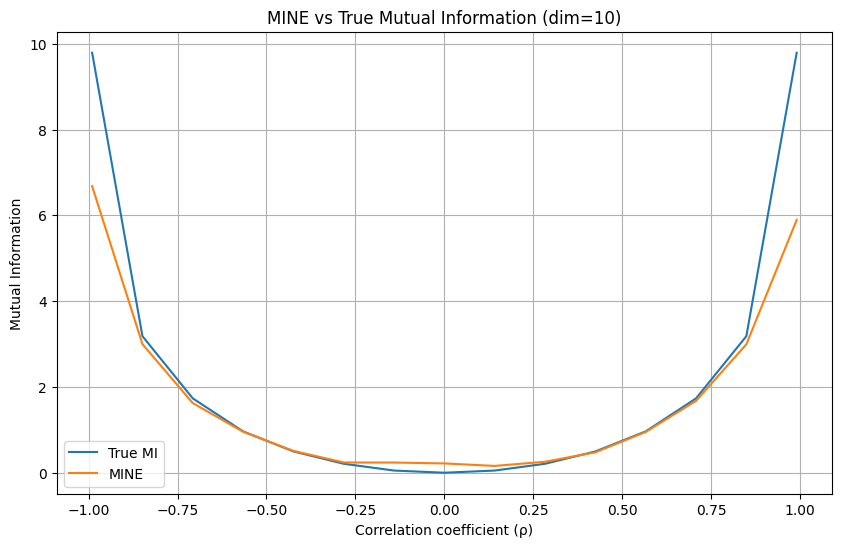

In [57]:
d = run_experiment(dim=10, n_samples=10000, n_iterations=1000)

  0%|                                                                         | 0/10 [00:00<?, ?it/s]

Dim: 2 samples: 10000
Epoch 100/2000, Loss: -1.9040
Early stopping at epoch 141
Epoch 100/2000, Loss: -0.6439
Early stopping at epoch 123
Epoch 100/2000, Loss: -0.3445
Early stopping at epoch 135
Epoch 100/2000, Loss: -0.1863
Epoch 200/2000, Loss: -0.1885
Early stopping at epoch 215
Epoch 100/2000, Loss: -0.1005
Early stopping at epoch 116
Epoch 100/2000, Loss: -0.0375
Early stopping at epoch 186
Early stopping at epoch 82
Epoch 100/2000, Loss: -0.0020
Epoch 200/2000, Loss: -0.0027
Epoch 300/2000, Loss: -0.0030
Epoch 400/2000, Loss: -0.0038
Early stopping at epoch 433
Epoch 100/2000, Loss: -0.0110
Early stopping at epoch 108
Epoch 100/2000, Loss: -0.0434
Early stopping at epoch 174
Epoch 100/2000, Loss: -0.1034
Early stopping at epoch 171
Early stopping at epoch 76
Epoch 100/2000, Loss: -0.3366
Early stopping at epoch 139
Epoch 100/2000, Loss: -0.6332
Early stopping at epoch 182
Epoch 100/2000, Loss: -1.9285
Epoch 200/2000, Loss: -1.9064
Early stopping at epoch 230


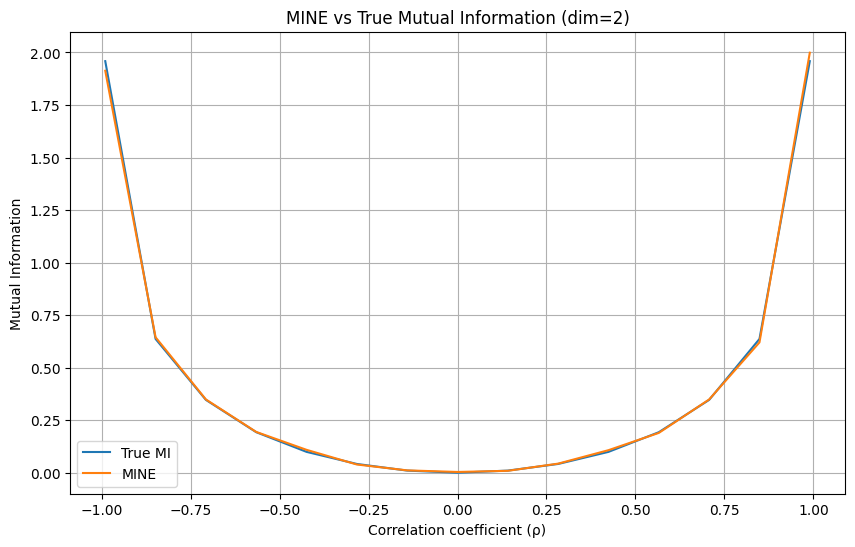

 10%|██████▍                                                         | 1/10 [01:52<16:48, 112.05s/it]

Dim: 4 samples: 14444
Epoch 100/2000, Loss: -3.7835
Early stopping at epoch 154
Epoch 100/2000, Loss: -1.2192
Epoch 200/2000, Loss: -1.2500
Early stopping at epoch 294
Epoch 100/2000, Loss: -0.6789
Early stopping at epoch 145
Epoch 100/2000, Loss: -0.3736
Early stopping at epoch 158
Epoch 100/2000, Loss: -0.1953
Early stopping at epoch 106
Epoch 100/2000, Loss: -0.0883
Early stopping at epoch 138
Epoch 100/2000, Loss: -0.0209
Epoch 200/2000, Loss: -0.0268
Epoch 300/2000, Loss: -0.0290
Early stopping at epoch 332
Epoch 100/2000, Loss: -0.0051
Epoch 200/2000, Loss: -0.0074
Epoch 300/2000, Loss: -0.0109
Epoch 400/2000, Loss: -0.0145
Epoch 500/2000, Loss: -0.0180
Early stopping at epoch 583
Epoch 100/2000, Loss: -0.0260
Early stopping at epoch 105
Epoch 100/2000, Loss: -0.0860
Early stopping at epoch 141
Epoch 100/2000, Loss: -0.1881
Early stopping at epoch 113
Epoch 100/2000, Loss: -0.3958
Early stopping at epoch 136
Epoch 100/2000, Loss: -0.7026
Early stopping at epoch 139
Epoch 100/2000

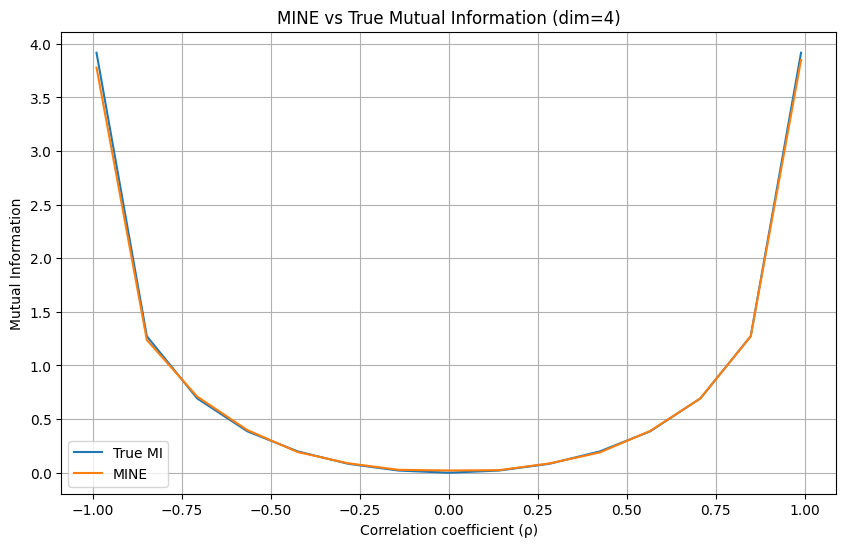

 20%|████████████▊                                                   | 2/10 [04:50<20:11, 151.39s/it]

Dim: 6 samples: 18888
Epoch 100/2000, Loss: -5.5804
Epoch 200/2000, Loss: -5.7103
Epoch 300/2000, Loss: -5.3817
Early stopping at epoch 317
Epoch 100/2000, Loss: -1.7509
Epoch 200/2000, Loss: -1.8527
Early stopping at epoch 230
Epoch 100/2000, Loss: -0.9905
Early stopping at epoch 170
Epoch 100/2000, Loss: -0.5547
Epoch 200/2000, Loss: -0.5599
Early stopping at epoch 265
Epoch 100/2000, Loss: -0.2989
Epoch 200/2000, Loss: -0.3184
Early stopping at epoch 269
Epoch 100/2000, Loss: -0.1307
Early stopping at epoch 163
Epoch 100/2000, Loss: -0.0377
Epoch 200/2000, Loss: -0.0445
Epoch 300/2000, Loss: -0.0512
Early stopping at epoch 387
Epoch 100/2000, Loss: -0.0084
Epoch 200/2000, Loss: -0.0167
Epoch 300/2000, Loss: -0.0237
Epoch 400/2000, Loss: -0.0310
Epoch 500/2000, Loss: -0.0345
Epoch 600/2000, Loss: -0.0431
Epoch 700/2000, Loss: -0.0475
Epoch 800/2000, Loss: -0.0574
Epoch 900/2000, Loss: -0.0609
Epoch 1000/2000, Loss: -0.0630
Epoch 1100/2000, Loss: -0.0682
Early stopping at epoch 1157
E

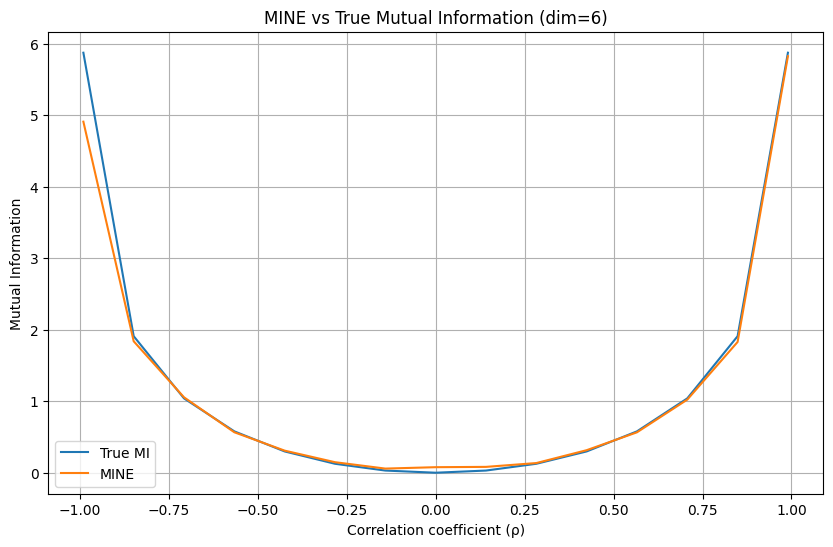

 30%|███████████████████▏                                            | 3/10 [11:12<29:54, 256.40s/it]

Dim: 8 samples: 23333
Epoch 100/2000, Loss: -7.0735
Epoch 200/2000, Loss: -8.9979
Epoch 300/2000, Loss: -9.2815
Epoch 400/2000, Loss: -13.6846
Early stopping at epoch 444
Epoch 100/2000, Loss: -2.3938
Early stopping at epoch 119
Epoch 100/2000, Loss: -1.3208
Epoch 200/2000, Loss: -1.3367
Early stopping at epoch 211
Epoch 100/2000, Loss: -0.7584
Epoch 200/2000, Loss: -0.7686
Early stopping at epoch 271
Epoch 100/2000, Loss: -0.4057
Epoch 200/2000, Loss: -0.4071
Epoch 300/2000, Loss: -0.4235
Early stopping at epoch 314
Epoch 100/2000, Loss: -0.1701
Early stopping at epoch 194
Epoch 100/2000, Loss: -0.0444
Epoch 200/2000, Loss: -0.0540
Epoch 300/2000, Loss: -0.0687
Epoch 400/2000, Loss: -0.0782
Epoch 500/2000, Loss: -0.0873
Epoch 600/2000, Loss: -0.1022
Epoch 700/2000, Loss: -0.1089
Epoch 800/2000, Loss: -0.1155
Early stopping at epoch 882
Epoch 100/2000, Loss: -0.0110
Epoch 200/2000, Loss: -0.0233
Epoch 300/2000, Loss: -0.0345
Epoch 400/2000, Loss: -0.0468
Epoch 500/2000, Loss: -0.0557
E

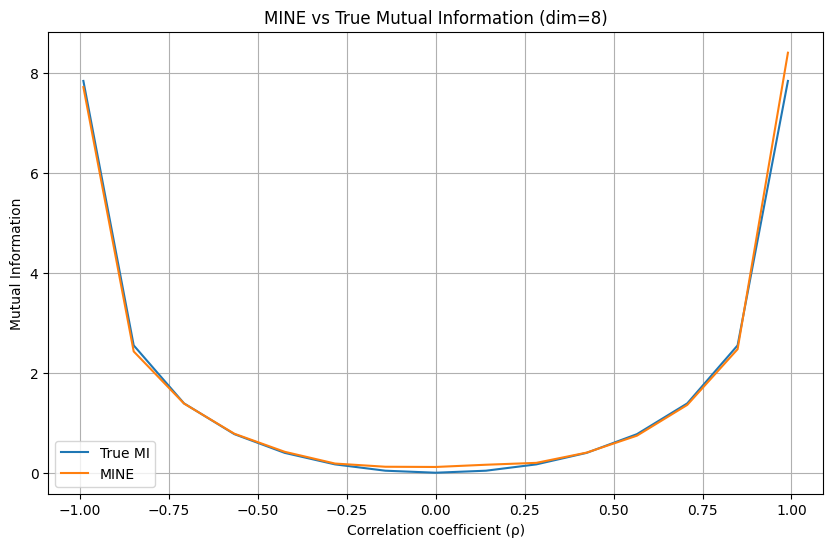

 40%|█████████████████████████▌                                      | 4/10 [21:23<39:38, 396.39s/it]

Dim: 10 samples: 27777
Epoch 100/2000, Loss: -8.1111
Epoch 200/2000, Loss: -15.4811
Epoch 300/2000, Loss: -18.8131
Early stopping at epoch 385
Epoch 100/2000, Loss: -2.8980
Early stopping at epoch 115
Epoch 100/2000, Loss: -1.6827
Early stopping at epoch 174
Epoch 100/2000, Loss: -0.9100
Epoch 200/2000, Loss: -0.9607
Epoch 300/2000, Loss: -0.9150
Early stopping at epoch 343
Epoch 100/2000, Loss: -0.4829
Early stopping at epoch 140
Epoch 100/2000, Loss: -0.2190
Early stopping at epoch 102
Epoch 100/2000, Loss: -0.0610
Epoch 200/2000, Loss: -0.0753
Epoch 300/2000, Loss: -0.0824
Epoch 400/2000, Loss: -0.0924
Epoch 500/2000, Loss: -0.1066
Epoch 600/2000, Loss: -0.1139
Epoch 700/2000, Loss: -0.1237
Epoch 800/2000, Loss: -0.1392
Epoch 900/2000, Loss: -0.1397
Epoch 1000/2000, Loss: -0.1516
Epoch 1100/2000, Loss: -0.1547
Epoch 1200/2000, Loss: -0.1689
Early stopping at epoch 1275
Epoch 100/2000, Loss: -0.0136
Epoch 200/2000, Loss: -0.0301
Epoch 300/2000, Loss: -0.0447
Epoch 400/2000, Loss: -0.

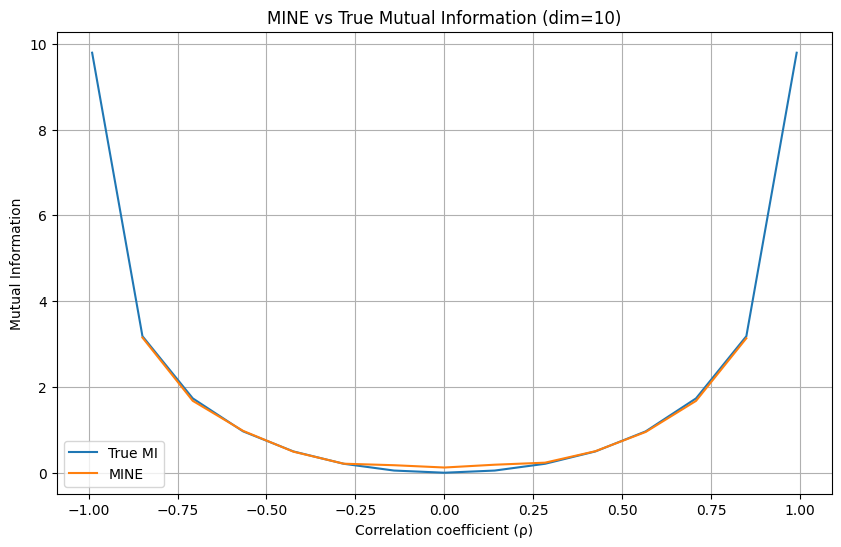

 50%|████████████████████████████████                                | 5/10 [33:13<42:28, 509.70s/it]

Dim: 12 samples: 32222
Epoch 100/2000, Loss: -10.2692
Epoch 200/2000, Loss: -18.1834
Epoch 300/2000, Loss: nan
Early stopping at epoch 302
Epoch 100/2000, Loss: -3.5112
Epoch 200/2000, Loss: -3.6134
Early stopping at epoch 251
Epoch 100/2000, Loss: -1.9403
Early stopping at epoch 136
Epoch 100/2000, Loss: -1.1303
Early stopping at epoch 119
Epoch 100/2000, Loss: -0.5826
Epoch 200/2000, Loss: -0.6066
Early stopping at epoch 264
Epoch 100/2000, Loss: -0.2514
Epoch 200/2000, Loss: -0.2740
Epoch 300/2000, Loss: -0.2669
Early stopping at epoch 363
Epoch 100/2000, Loss: -0.0723
Epoch 200/2000, Loss: -0.0862
Epoch 300/2000, Loss: -0.1040
Epoch 400/2000, Loss: -0.1200
Epoch 500/2000, Loss: -0.1286
Epoch 600/2000, Loss: -0.1418
Epoch 700/2000, Loss: -0.1596
Epoch 800/2000, Loss: -0.1660
Epoch 900/2000, Loss: -0.1746
Epoch 1000/2000, Loss: -0.1828
Epoch 1100/2000, Loss: -0.1878
Epoch 1200/2000, Loss: -0.2056
Epoch 1300/2000, Loss: -0.2069
Early stopping at epoch 1319
Epoch 100/2000, Loss: -0.018

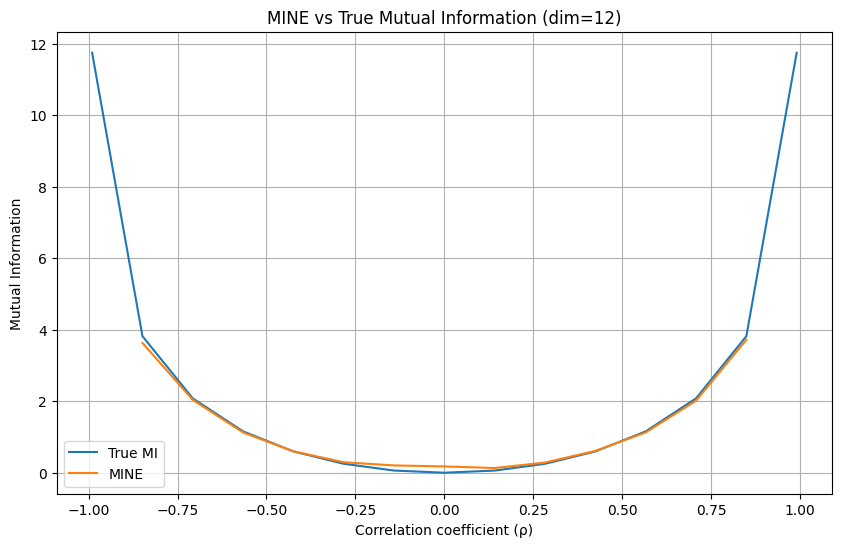

 60%|██████████████████████████████████████▍                         | 6/10 [59:19<57:54, 868.73s/it]

Dim: 14 samples: 36666
Epoch 100/2000, Loss: -15.4789
Epoch 200/2000, Loss: nan
Early stopping at epoch 239
Epoch 100/2000, Loss: -4.3039
Early stopping at epoch 150
Epoch 100/2000, Loss: -2.2535
Early stopping at epoch 160
Epoch 100/2000, Loss: -1.2981
Early stopping at epoch 146
Epoch 100/2000, Loss: -0.6792
Epoch 200/2000, Loss: -0.6989
Early stopping at epoch 284
Epoch 100/2000, Loss: -0.2877
Epoch 200/2000, Loss: -0.3083
Epoch 300/2000, Loss: -0.3095
Epoch 400/2000, Loss: -0.3327
Epoch 500/2000, Loss: -0.3263
Early stopping at epoch 532
Epoch 100/2000, Loss: -0.0931
Epoch 200/2000, Loss: -0.1059
Epoch 300/2000, Loss: -0.1196
Epoch 400/2000, Loss: -0.1370
Epoch 500/2000, Loss: -0.1544
Epoch 600/2000, Loss: -0.1648
Epoch 700/2000, Loss: -0.1789
Early stopping at epoch 716
Epoch 100/2000, Loss: -0.0225
Epoch 200/2000, Loss: -0.0450
Epoch 300/2000, Loss: -0.0649
Epoch 400/2000, Loss: -0.0819
Epoch 500/2000, Loss: -0.0935
Epoch 600/2000, Loss: -0.1118
Epoch 700/2000, Loss: -0.1267
Epoc

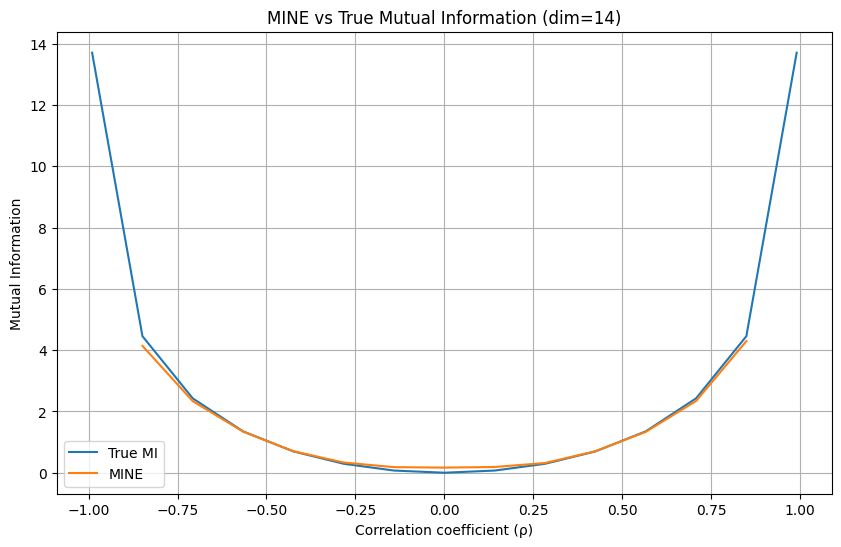

 70%|███████████████████████████████████████████▍                  | 7/10 [1:13:20<42:59, 859.77s/it]

Dim: 16 samples: 41111
Epoch 100/2000, Loss: -20.8400
Early stopping at epoch 198
Epoch 100/2000, Loss: -4.4428
Early stopping at epoch 169
Epoch 100/2000, Loss: -2.6266
Early stopping at epoch 179
Epoch 100/2000, Loss: -1.4669
Early stopping at epoch 147
Epoch 100/2000, Loss: -0.7313
Epoch 200/2000, Loss: -0.7764
Early stopping at epoch 201
Epoch 100/2000, Loss: -0.3353
Epoch 200/2000, Loss: -0.3506
Epoch 300/2000, Loss: -0.3645
Epoch 400/2000, Loss: -0.3714
Early stopping at epoch 401
Epoch 100/2000, Loss: -0.0972
Epoch 200/2000, Loss: -0.1136
Epoch 300/2000, Loss: -0.1280
Epoch 400/2000, Loss: -0.1413
Epoch 500/2000, Loss: -0.1589
Epoch 600/2000, Loss: -0.1698
Epoch 700/2000, Loss: -0.1787
Epoch 800/2000, Loss: -0.1877
Epoch 900/2000, Loss: -0.2016
Epoch 1000/2000, Loss: -0.2084
Early stopping at epoch 1067
Epoch 100/2000, Loss: -0.0203
Epoch 200/2000, Loss: -0.0445
Epoch 300/2000, Loss: -0.0686
Epoch 400/2000, Loss: -0.0864
Epoch 500/2000, Loss: -0.1047
Epoch 600/2000, Loss: -0.112

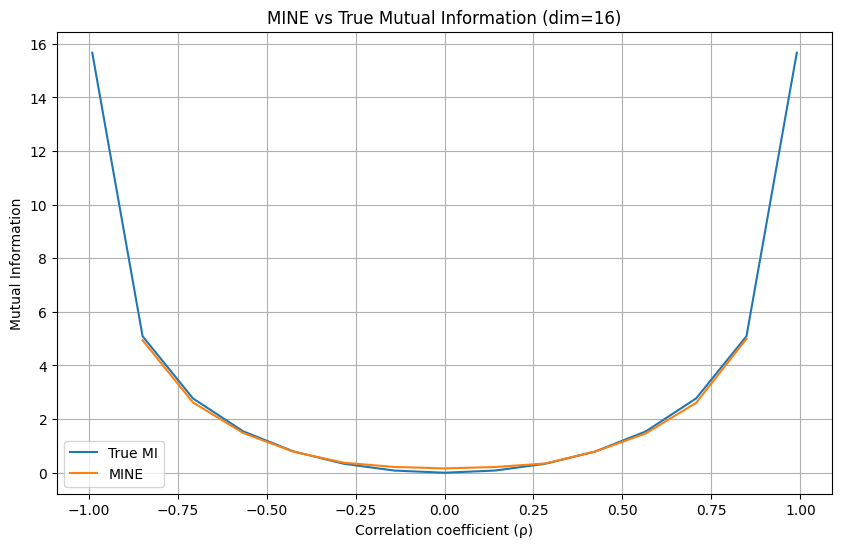

 80%|█████████████████████████████████████████████████▌            | 8/10 [1:27:52<28:46, 863.38s/it]

Dim: 18 samples: 45555
Epoch 100/2000, Loss: -18.3121
Early stopping at epoch 171
Epoch 100/2000, Loss: -4.7464
Early stopping at epoch 105
Epoch 100/2000, Loss: -2.8212
Early stopping at epoch 147
Epoch 100/2000, Loss: -1.6601
Early stopping at epoch 101
Epoch 100/2000, Loss: -0.8743
Epoch 200/2000, Loss: -0.8815
Epoch 300/2000, Loss: -0.9076
Early stopping at epoch 307
Epoch 100/2000, Loss: -0.3796
Epoch 200/2000, Loss: -0.3946
Epoch 300/2000, Loss: -0.4034
Epoch 400/2000, Loss: -0.4132
Epoch 500/2000, Loss: -0.4235
Early stopping at epoch 505
Epoch 100/2000, Loss: -0.1089
Epoch 200/2000, Loss: -0.1277
Epoch 300/2000, Loss: -0.1454
Epoch 400/2000, Loss: -0.1595
Epoch 500/2000, Loss: -0.1777
Epoch 600/2000, Loss: -0.1791
Epoch 700/2000, Loss: -0.1947
Epoch 800/2000, Loss: -0.2070
Epoch 900/2000, Loss: -0.2159
Early stopping at epoch 907
Epoch 100/2000, Loss: -0.0220
Epoch 200/2000, Loss: -0.0479
Epoch 300/2000, Loss: -0.0687
Epoch 400/2000, Loss: -0.0855
Epoch 500/2000, Loss: -0.1023


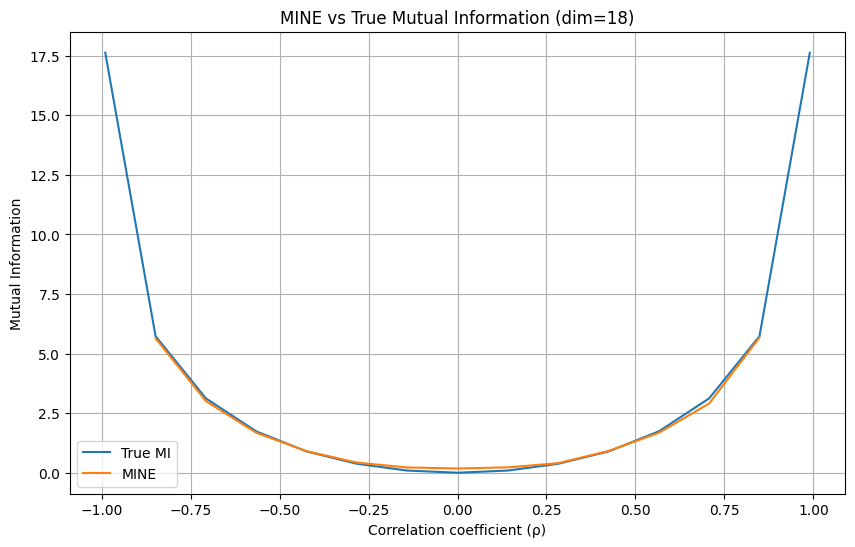

 90%|██████████████████████████████████████████████████████▉      | 9/10 [2:21:50<26:45, 1605.91s/it]

Dim: 20 samples: 50000
Epoch 100/2000, Loss: -31.3529
Early stopping at epoch 158
Epoch 100/2000, Loss: -5.6114
Early stopping at epoch 162
Epoch 100/2000, Loss: -3.1924
Early stopping at epoch 158
Epoch 100/2000, Loss: -1.8410
Early stopping at epoch 147
Epoch 100/2000, Loss: -0.9664
Epoch 200/2000, Loss: -0.9996
Early stopping at epoch 274
Epoch 100/2000, Loss: -0.4214
Epoch 200/2000, Loss: -0.4363
Epoch 300/2000, Loss: -0.4470
Early stopping at epoch 343
Epoch 100/2000, Loss: -0.1201
Epoch 200/2000, Loss: -0.1383
Epoch 300/2000, Loss: -0.1603
Epoch 400/2000, Loss: -0.1692
Epoch 500/2000, Loss: -0.1856
Epoch 600/2000, Loss: -0.1957
Epoch 700/2000, Loss: -0.2111
Epoch 800/2000, Loss: -0.2180
Epoch 900/2000, Loss: -0.2289
Epoch 1000/2000, Loss: -0.2298
Epoch 1100/2000, Loss: -0.2452
Early stopping at epoch 1162
Epoch 100/2000, Loss: -0.0249
Epoch 200/2000, Loss: -0.0548
Epoch 300/2000, Loss: -0.0757
Epoch 400/2000, Loss: -0.0945
Epoch 500/2000, Loss: -0.1129
Epoch 600/2000, Loss: -0.12

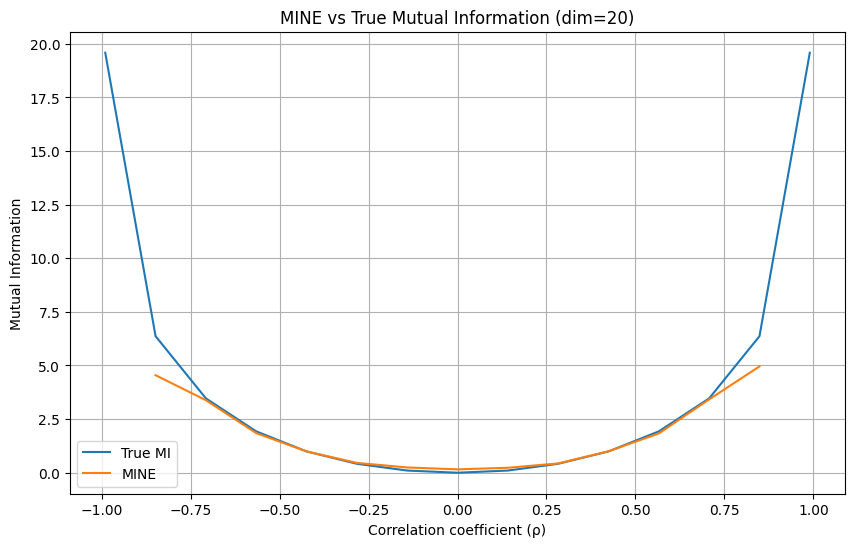

100%|████████████████████████████████████████████████████████████| 10/10 [2:55:10<00:00, 1051.07s/it]

CPU times: user 1h 39min 41s, sys: 33min 49s, total: 2h 13min 31s
Wall time: 2h 55min 10s


In [58]:
%%time

def calculate_n_samples(dim, min_dim=2, max_dim=20, min_samples=10000, max_samples=50000):
    slope = (max_samples - min_samples) / (max_dim - min_dim)
    n_samples = int(min_samples + slope * (dim - min_dim))
    return n_samples

dfs = []
for dim in tqdm(range(2, 21, 2)):
    n_samples = calculate_n_samples(dim)
    print(f"Dim: {dim} samples: {n_samples}")
    dfs.append(run_experiment(dim=dim, n_samples=n_samples, n_iterations=2000))
    

In [59]:
dfs

[         rho   true_mi  estimated_mi  dim
 0  -0.990000  1.958518      1.912773    2
 1  -0.848571  0.636614      0.644479    2
 2  -0.707143  0.346625      0.348611    2
 3  -0.565714  0.192855      0.194066    2
 4  -0.424286  0.099237      0.108902    2
 5  -0.282857  0.041695      0.039087    2
 6  -0.141429  0.010102      0.011097    2
 7   0.000000 -0.000000      0.003614    2
 8   0.141429  0.010102      0.009099    2
 9   0.282857  0.041695      0.043283    2
 10  0.424286  0.099237      0.107311    2
 11  0.565714  0.192855      0.189485    2
 12  0.707143  0.346625      0.348640    2
 13  0.848571  0.636614      0.620276    2
 14  0.990000  1.958518      1.998634    2,
          rho   true_mi  estimated_mi  dim
 0  -0.990000  3.917036      3.779014    4
 1  -0.848571  1.273228      1.237464    4
 2  -0.707143  0.693249      0.710684    4
 3  -0.565714  0.385711      0.397193    4
 4  -0.424286  0.198473      0.192586    4
 5  -0.282857  0.083390      0.088098    4
 6  -0.141

# Save results

In [61]:
results_df = pd.concat(dfs)

results_df.to_csv('./dsc-261-project-f24/results/df_mine_corr_gaussians_exp.csv', index=False)

# More results
## dim 20-30

  0%|                                                                          | 0/4 [00:00<?, ?it/s]

Dim: 22 samples: 50000
Epoch 100/2000, Loss: nan
Early stopping at epoch 136
Epoch 100/2000, Loss: -6.0435
Epoch 200/2000, Loss: -5.8937
Epoch 300/2000, Loss: -6.8176
Early stopping at epoch 349
Epoch 100/2000, Loss: -3.4933
Early stopping at epoch 169
Epoch 100/2000, Loss: -2.0148
Early stopping at epoch 163
Epoch 100/2000, Loss: -1.0339
Epoch 200/2000, Loss: -1.0616
Epoch 300/2000, Loss: -1.0704
Epoch 400/2000, Loss: -1.1161
Early stopping at epoch 450
Epoch 100/2000, Loss: -0.4561
Epoch 200/2000, Loss: -0.4722
Epoch 300/2000, Loss: -0.4820
Epoch 400/2000, Loss: -0.4994
Epoch 500/2000, Loss: -0.5101
Epoch 600/2000, Loss: -0.5162
Epoch 700/2000, Loss: -0.5145
Early stopping at epoch 702
Epoch 100/2000, Loss: -0.1284
Epoch 200/2000, Loss: -0.1464
Epoch 300/2000, Loss: -0.1622
Epoch 400/2000, Loss: -0.1862
Epoch 500/2000, Loss: -0.1984
Epoch 600/2000, Loss: -0.2064
Epoch 700/2000, Loss: -0.2150
Epoch 800/2000, Loss: -0.2336
Epoch 900/2000, Loss: -0.2379
Epoch 1000/2000, Loss: -0.2471
Ea

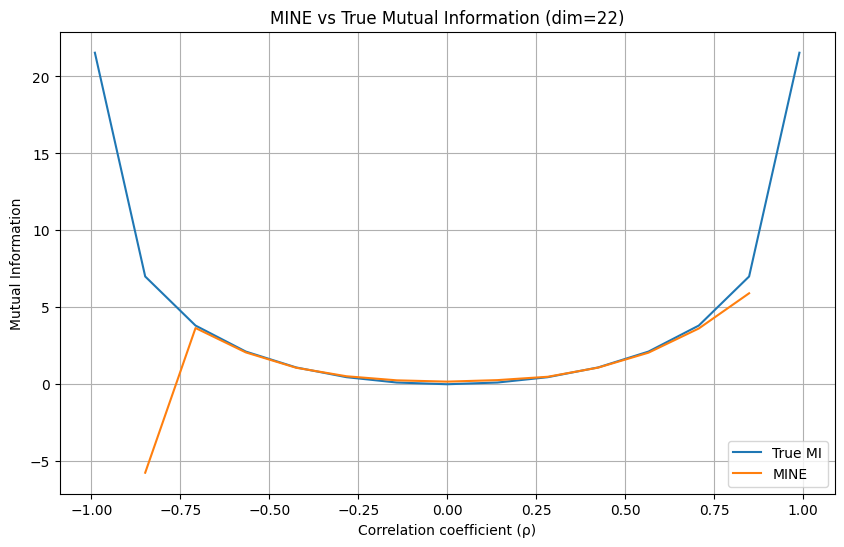

 25%|███████████████▌                                              | 1/4 [23:26<1:10:19, 1406.67s/it]

Dim: 24 samples: 57500
Epoch 100/2000, Loss: nan
Early stopping at epoch 128
Epoch 100/2000, Loss: -6.1249
Epoch 200/2000, Loss: -7.9266
Epoch 300/2000, Loss: -10.5378
Epoch 400/2000, Loss: -12.7838
Epoch 500/2000, Loss: -11.1470
Early stopping at epoch 575
Epoch 100/2000, Loss: -3.6871
Early stopping at epoch 129
Epoch 100/2000, Loss: -2.1131
Early stopping at epoch 155
Epoch 100/2000, Loss: -1.1381
Epoch 200/2000, Loss: -1.1746
Epoch 300/2000, Loss: -1.1670
Epoch 400/2000, Loss: -1.1920
Early stopping at epoch 470
Epoch 100/2000, Loss: -0.4894
Epoch 200/2000, Loss: -0.5050
Epoch 300/2000, Loss: -0.5263
Early stopping at epoch 357
Epoch 100/2000, Loss: -0.1492
Epoch 200/2000, Loss: -0.1650
Epoch 300/2000, Loss: -0.1794
Epoch 400/2000, Loss: -0.2028
Epoch 500/2000, Loss: -0.2135
Epoch 600/2000, Loss: -0.2225
Epoch 700/2000, Loss: -0.2340
Epoch 800/2000, Loss: -0.2397
Epoch 900/2000, Loss: -0.2544
Epoch 1000/2000, Loss: -0.2576
Early stopping at epoch 1001
Epoch 100/2000, Loss: -0.0288


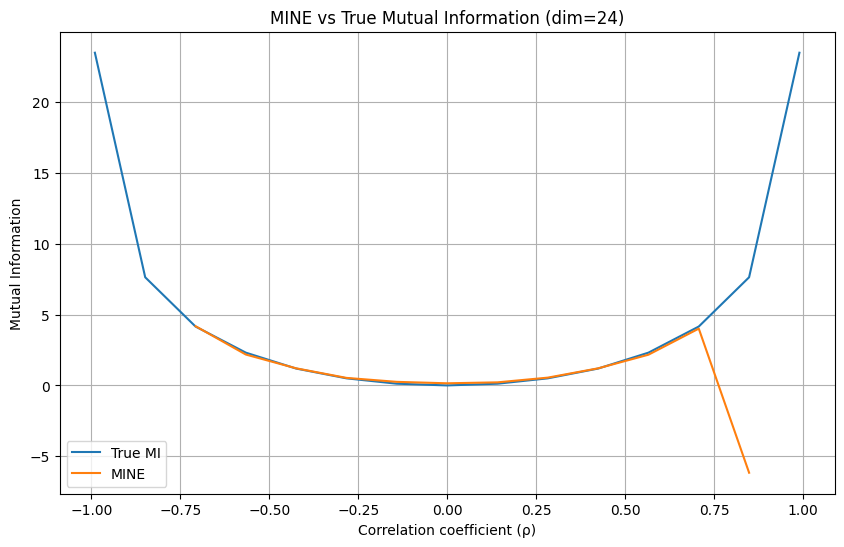

 50%|████████████████████████████████                                | 2/4 [47:40<47:48, 1434.20s/it]

Dim: 26 samples: 65000
Epoch 100/2000, Loss: nan
Early stopping at epoch 113
Epoch 100/2000, Loss: -7.5474
Epoch 200/2000, Loss: -10.9717
Epoch 300/2000, Loss: -18.9495
Early stopping at epoch 350
Epoch 100/2000, Loss: -3.8752
Epoch 200/2000, Loss: -4.1060
Early stopping at epoch 216
Epoch 100/2000, Loss: -2.3582
Early stopping at epoch 164
Epoch 100/2000, Loss: -1.2167
Early stopping at epoch 116
Epoch 100/2000, Loss: -0.5372
Epoch 200/2000, Loss: -0.5574
Early stopping at epoch 299
Epoch 100/2000, Loss: -0.1537
Epoch 200/2000, Loss: -0.1707
Epoch 300/2000, Loss: -0.1904
Epoch 400/2000, Loss: -0.2032
Epoch 500/2000, Loss: -0.2154
Epoch 600/2000, Loss: -0.2274
Epoch 700/2000, Loss: -0.2363
Early stopping at epoch 707
Epoch 100/2000, Loss: -0.0305
Epoch 200/2000, Loss: -0.0613
Epoch 300/2000, Loss: -0.0822
Epoch 400/2000, Loss: -0.0983
Epoch 500/2000, Loss: -0.1113
Epoch 600/2000, Loss: -0.1169
Epoch 700/2000, Loss: -0.1273
Epoch 800/2000, Loss: -0.1368
Epoch 900/2000, Loss: -0.1361
Epo

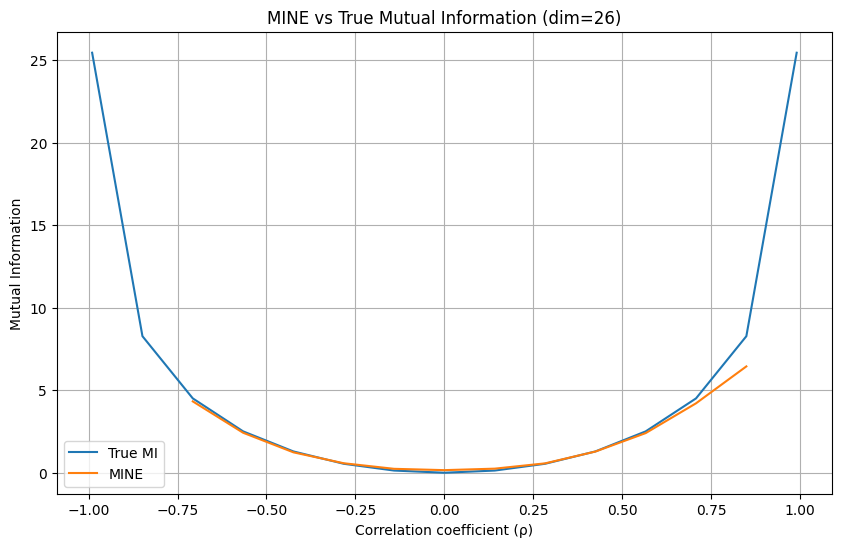

 75%|██████████████████████████████████████████████▌               | 3/4 [1:11:08<23:42, 1422.37s/it]

Dim: 28 samples: 72500
Epoch 100/2000, Loss: nan
Early stopping at epoch 104
Epoch 100/2000, Loss: -8.2560
Epoch 200/2000, Loss: -14.4918
Early stopping at epoch 274
Epoch 100/2000, Loss: -4.3248
Early stopping at epoch 181
Epoch 100/2000, Loss: -2.4440
Early stopping at epoch 176
Epoch 100/2000, Loss: -1.3231
Epoch 200/2000, Loss: -1.3657
Early stopping at epoch 253
Epoch 100/2000, Loss: -0.5910
Epoch 200/2000, Loss: -0.5818
Epoch 300/2000, Loss: -0.5978
Early stopping at epoch 327
Epoch 100/2000, Loss: -0.1636
Epoch 200/2000, Loss: -0.1792
Epoch 300/2000, Loss: -0.1977
Epoch 400/2000, Loss: -0.2123
Epoch 500/2000, Loss: -0.2255
Epoch 600/2000, Loss: -0.2280
Epoch 700/2000, Loss: -0.2401
Epoch 800/2000, Loss: -0.2525
Epoch 900/2000, Loss: -0.2486
Epoch 1000/2000, Loss: -0.2657
Early stopping at epoch 1059
Epoch 100/2000, Loss: -0.0303
Epoch 200/2000, Loss: -0.0595
Epoch 300/2000, Loss: -0.0807
Epoch 400/2000, Loss: -0.0953
Epoch 500/2000, Loss: -0.1054
Epoch 600/2000, Loss: -0.1166
Ep

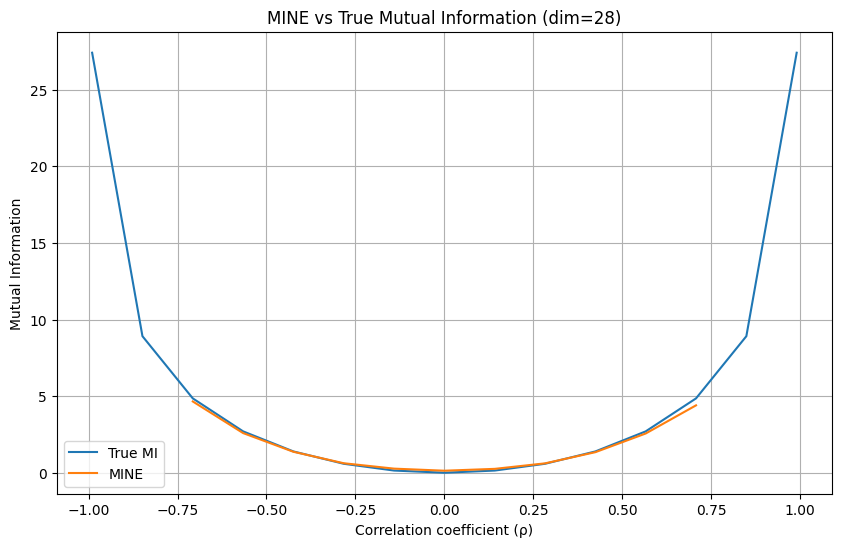

100%|██████████████████████████████████████████████████████████████| 4/4 [1:42:36<00:00, 1539.18s/it]

CPU times: user 1h 25min 50s, sys: 29min 31s, total: 1h 55min 21s
Wall time: 1h 42min 36s


In [62]:
%%time

def calculate_n_samples(dim, min_dim=22, max_dim=30, min_samples=50000, max_samples=80000):
    slope = (max_samples - min_samples) / (max_dim - min_dim)
    n_samples = int(min_samples + slope * (dim - min_dim))
    return n_samples

dfs_2 = []
for dim in tqdm(range(22, 30, 2)):
    n_samples = calculate_n_samples(dim)
    print(f"Dim: {dim} samples: {n_samples}")
    dfs_2.append(run_experiment(dim=dim, n_samples=n_samples, n_iterations=2000))
    

In [72]:
more_results = pd.concat(dfs_2)
more_results.to_csv('./dsc-261-project-f24/results/df_mine_corr_gaussians_exp_20_to_30.csv', index=False)

# All results

In [76]:
res_1 = pd.read_csv('./dsc-261-project-f24/results/df_mine_corr_gaussians_exp.csv')
res_2 = pd.read_csv('./dsc-261-project-f24/results/df_mine_corr_gaussians_exp_20_to_30.csv')
results_all = pd.concat([res_1, res_2])
results_all.to_csv('./dsc-261-project-f24/results/df_mine_corr_gaussians_exp_2_to_30.csv', index=False)